In [1]:
import os
import cv2
import pdb
import time
import warnings
import random
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from matplotlib import image
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
!pip install segmentation-models-pytorch
import segmentation_models_pytorch as sm
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset, sampler
from matplotlib import pyplot as plt
!pip install albumentations
from albumentations import (HorizontalFlip, RandomBrightnessContrast,VerticalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise, RandomCrop)
import albumentations as A
from albumentations.pytorch import ToTensor

unet_rn18_final = sm.Unet('resnet18', classes=4, activation=None, in_channels=3)

     |████████████████████████████████| 66 kB 2.2 MB/s eta 0:00:011
     |████████████████████████████████| 58 kB 4.3 MB/s  eta 0:00:01
     |████████████████████████████████| 244 kB 22.3 MB/s eta 0:00:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12419 sha256=d93ac21a2af0fa5f3a278c4f2738eb9ee3e2cad78c4e33b2748e80d257b8110c
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=24d835fdee011ccb05840d49f2d78e96bb5fcc9a51e0683f22e41983a8e25b06
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [2]:
# Initialize mode and load trained weights
def weight_loader(model,path):
    ckpt_path = path
    device = torch.device("cuda")
    model.to(device)
    model.eval()
    state = torch.load(ckpt_path, map_location=lambda storage, loc: storage)
    model.load_state_dict(state["state_dict"])
    return model

unet_rn18_final = weight_loader(unet_rn18_final,'../input/finalresnet18model/final_model-0.58.pth')


unet_rn18_final.eval()

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [3]:
class Model:
    def __init__(self, models):
        self.models = models
    def __call__(self, x):
        res = []
        x = x.cuda()
        with torch.no_grad():
            for m in self.models:
                res.append(m(x))
        x = torch.flip(x,dims = [-1])
        with torch.no_grad():
            for m in self.models:
                flipped_mask = m(x)
                mask = torch.flip(flipped_mask,dims = [-1])
                res.append(mask)
        res = torch.stack(res)
        return torch.sigmoid(torch.mean(res, dim=0))

model = Model([unet_rn18_final])

In [4]:
sample_submission_path = '../input/datathon-challenge/sample_submission.csv'
test_data_folder =  "../input/datathon-challenge/Testing_Imgs/Testing_Imgs"

In [5]:
class TestDataset(Dataset):
    '''Dataset for test prediction'''
    def __init__(self, root, df, mean, std):
        self.root = root
        df['ImageId'] = df['filename_class'].apply(lambda x: x.split('_')[0])
        self.fnames = df['ImageId'].unique().tolist()
        self.num_samples = len(self.fnames)
        self.transform = Compose(
            [   
                ToTensor(),
            ]
        )

    def __getitem__(self, idx):
        fname = self.fnames[idx]
        path = os.path.join(self.root, fname+".jpeg")
        image = cv2.imread(path)
        images = self.transform(image=image)["image"]
        return fname, images

    def __len__(self):
        return self.num_samples

In [6]:
df = pd.read_csv(sample_submission_path)
ts = DataLoader(
    TestDataset(test_data_folder, df, None, None),
    batch_size=1,
    shuffle=False,
    num_workers=10,
    pin_memory=True
)
orgsizes=[]
for i in ts:
    orgsizes.append((i[1].shape[3], i[1].shape[2]))
orsz = [val for val in orgsizes for _ in range(4)]

In [7]:
class TestDataset(Dataset):
    '''Dataset for test prediction'''
    def __init__(self, root, df, mean, std):
        self.root = root
        df['ImageId'] = df['filename_class'].apply(lambda x: x.split('_')[0])
        self.fnames = df['ImageId'].unique().tolist()
        self.num_samples = len(self.fnames)
        self.transform = Compose(
            [   
                Resize(512,512),
                ToTensor(),
            ]
        )

    def __getitem__(self, idx):
        fname = self.fnames[idx]
        path = os.path.join(self.root, fname+".jpeg")
        image = cv2.imread(path)
        images = self.transform(image=image)["image"]
        return fname, images

    def __len__(self):
        return self.num_samples

In [8]:
def post_process(probability, threshold, min_size):
    '''Post processing of each predicted mask, components with lesser number of pixels
    than `min_size` are ignored'''
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((512, 512), np.float32)
    num = 0
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions, num

In [13]:
best_threshold = 0.8
num_workers = 10
batch_size = 1
min_size = 400
df = pd.read_csv('../input/datathon-challenge/sample_submission.csv')
testset = DataLoader(
    TestDataset(test_data_folder, df, mean=None, std=None),
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

In [14]:
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(rle, imgshape):
    height= imgshape[0]
    width = imgshape[1]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return np.flipud( np.rot90( mask.reshape(height, width), k=1 ) )

In [15]:
def null_augment   (input): return input
def flip_lr_augment(input): return torch.flip(input, dims=[2])
def flip_ud_augment(input): return torch.flip(input, dims=[3])

def null_inverse_augment   (logit): return logit
def flip_lr_inverse_augment(logit): return torch.flip(logit, dims=[2])
def flip_ud_inverse_augment(logit): return torch.flip(logit, dims=[3])

augment = (
        (null_augment,   null_inverse_augment   ),
        (flip_lr_augment,flip_lr_inverse_augment),
        (flip_ud_augment,flip_ud_inverse_augment),
    )

In [16]:
model = unet_rn18_final
device='cuda'
predictions = []
for i, batch in enumerate(tqdm(testset)):
    fnames, images = batch
    #print('images', images.shape)
    images = images.cuda()
    batch_preds = 0
    probabilities = []
#     model = model.cuda()
    for k, (a, inv_a) in enumerate(augment):
            logit = model(a(images))
            p = inv_a(torch.sigmoid(logit))

            if k ==0:
                probability  = p**0.5
            else:
                probability += p**0.5
    probability = probability/len(augment)
    probabilities.append(probability)

    batch_preds+=probability
    
    batch_preds = batch_preds.data.cpu().numpy()
    #print(batch_preds.shape)
    for fname, preds in zip(fnames, batch_preds):
        for cls, pred in enumerate(preds):
            #print(cls)
            pred, num = post_process(pred, best_threshold, min_size)
            rle = mask2rle(pred)
            name = fname + f"_{cls+1}"
            predictions.append([name, rle])


df_segmentation = pd.DataFrame(predictions, columns=['filename_class', 'encoded_mask'])
df_segmentation

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


,filename_class,encoded_mask
0,002f55f5-2f70-47cc-879c-395d9603346f_1,534 64 1031 126 1170 17 1542 173 2052 179 2564...
1,002f55f5-2f70-47cc-879c-395d9603346f_2,
2,002f55f5-2f70-47cc-879c-395d9603346f_3,
3,002f55f5-2f70-47cc-879c-395d9603346f_4,
4,003a6533-1af4-464a-bf95-2b4507d0ae4e_1,
...,...,...
2007,f8bc5312-f740-4d62-8476-1f1861d4152c_4,
2008,f8c6874e-6d91-4eba-b7cd-0e79e535902f_1,44775 6 45281 13 45789 17 46300 19 46811 20 47...
2009,f8c6874e-6d91-4eba-b7cd-0e79e535902f_2,
2010,f8c6874e-6d91-4eba-b7cd-0e79e535902f_3,


In [17]:
pred_masks = []
for i in range(len(predictions)):
    pred_masks.append(rle2mask(predictions[i][1], (512,512)))
    
pred_rle = []
for idx, p in enumerate(pred_masks): 
    img = cv2.resize(p, orsz[idx])
    pred_rle.append(mask2rle(img))
    
masks = []
for idx, p in enumerate(pred_masks): 
    img = cv2.resize(p, orsz[idx])
    masks.append(img)

rles = []
for idx, p in enumerate(masks): 
    rles.append(mask2rle(p))
df_segmentation['encoded_mask'] = rles

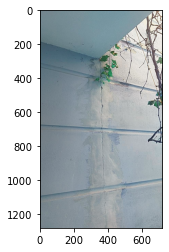

In [18]:
plt.imshow(cv2.imread("../input/datathon-challenge/Testing_Imgs/Testing_Imgs/"+df_segmentation["filename_class"].iloc[6].split('_')[0]+".jpeg"))

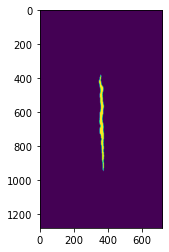

In [19]:
plt.imshow(rle2mask(df_segmentation["encoded_mask"].iloc[6], orsz[6]))

In [21]:
submit = pd.read_csv('../input/datathon-challenge/sample_submission.csv', converters={'encoded_mask': lambda e: ' '})
df_segmentation['filename_class'] = df_segmentation['filename_class'].apply(lambda x: x.split('_')[0]+"_id"+x.split('_')[1])
dfs = df_segmentation.merge(submit, on='filename_class', how='right', suffixes=['', 'a'])
dfs = dfs.drop('encoded_maska', axis=1)

In [22]:
dfs[dfs['encoded_mask']!='']

,filename_class,encoded_mask
0,002f55f5-2f70-47cc-879c-395d9603346f_id1,3271 1 3274 1 3277 1 3280 1 3283 1 3285 1 3288...
3,003a6533-1af4-464a-bf95-2b4507d0ae4e_id3,442013 13 443293 18 444567 3 444572 23 444597 ...
5,03a5a9a0-4ceb-4206-8308-e91f5bcfc0f6_id3,78111 1 78795 1 79477 6 80161 6 80845 7 81529 ...
7,03a9768d-3e09-4b9a-8f8b-eaea657c0960_id3,8069 3 8076 3 8083 1 9268 16 10468 17 11668 17...
8,03ba3998-470d-4098-b884-ff48357a7e00_id1,652259 1 652262 1 652265 1 652268 1 653794 12 ...
...,...,...
1103,f8ac3989-d2e2-4b81-9476-90d87fa0497c_id1,206341 1 207626 5 208899 1 208902 3 208907 3 2...
1106,f8ac3989-d2e2-4b81-9476-90d87fa0497c_id4,655976 1 655981 1 657263 8 658553 3 659842 2 6...
1107,f8b6c7ac-116b-41d4-8e40-460d24aea615_id1,328 75 567 78 807 79 1048 80 1288 80 1528 81 1...
1109,f8bc5312-f740-4d62-8476-1f1861d4152c_id1,4614 29 5892 33 5927 3 7170 42 8448 46 9726 50...


In [ ]:
dfs.to_csv('sub.csv', index=False)